In [16]:
################### #
# Attach packages ----
################### #
library(tidyverse)
library(tidymodels)
library(xgboost)
library(readxl)
library(writexl)

In [17]:
#################### #
# Read data and mutate: ----
# Include lat, long and municipalities in data set 
# - Keep only the 220 most common municipalities in the datase
#################### #

houses_raw <- read_excel("temp/houses.xlsx")

houses <- houses_raw %>%
  select(id, sqm, expense, tot_price, lat, lng, kommune_name) %>%
  mutate(kommune_factor = fct_lump_n(kommune_name, 220) %>% as.integer()) 

In [18]:
################## #
# Split data using the rsample package ----
# Set seed in order to make the analysis reproducible 
################### #
set.seed(42)

split <- initial_split(houses, prop = 3/4)
train_raw <- training(split)
test_raw  <- testing(split)

train <- train_raw %>%
  select(-kommune_name, -id)

test <- test_raw %>%
  select(-kommune_name, -id)

In [19]:
################### #
# Create a xgboost model ----
################### #

model <- boost_tree(trees = 350) %>%
  set_mode("regression") %>% 
  set_engine("xgboost") %>% 
  fit(tot_price ~ ., data = train)

In [20]:
################### #
# View summary of the prediction ----
# Use the package yardstick to get evaluation of the model
################### #

model_preds <- 
  predict(model, test) %>% 
  bind_cols(test_raw) %>% 
  rename(estimate     = .pred, 
         truth        = tot_price) %>%
  mutate(abs_dev      = abs(truth - estimate),
         abs_dev_perc = abs_dev/truth)

mape(model_preds, truth, estimate)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mape,standard,25.10124


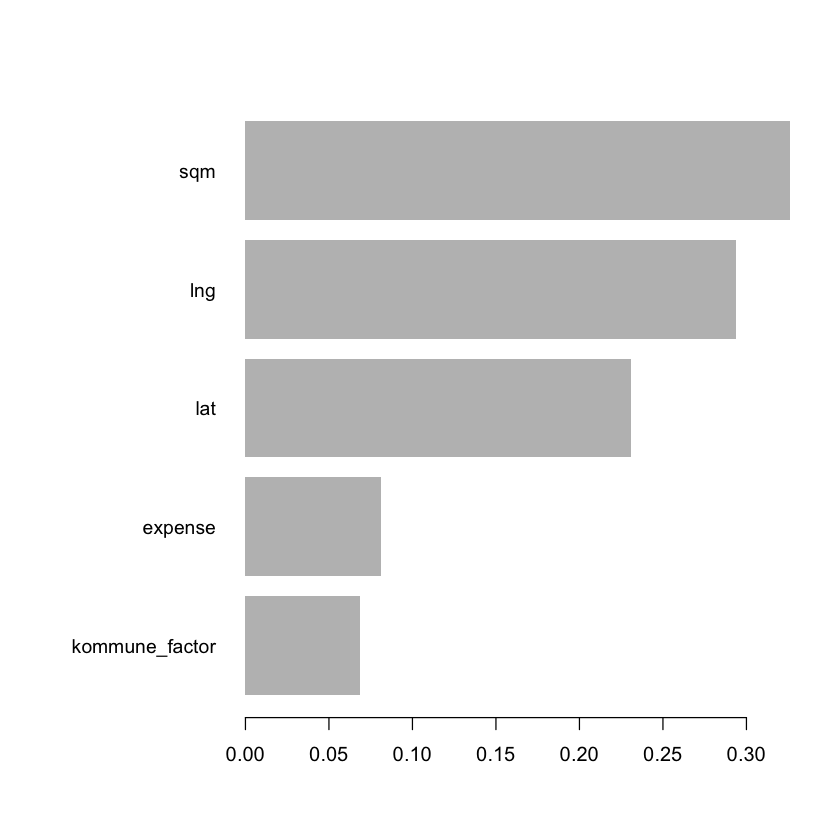

In [21]:
################### #
# Show importance plot of the model ----
# Using the package xgboost
################### #

xgb.importance(model = model$fit) %>% 
  xgb.plot.importance()

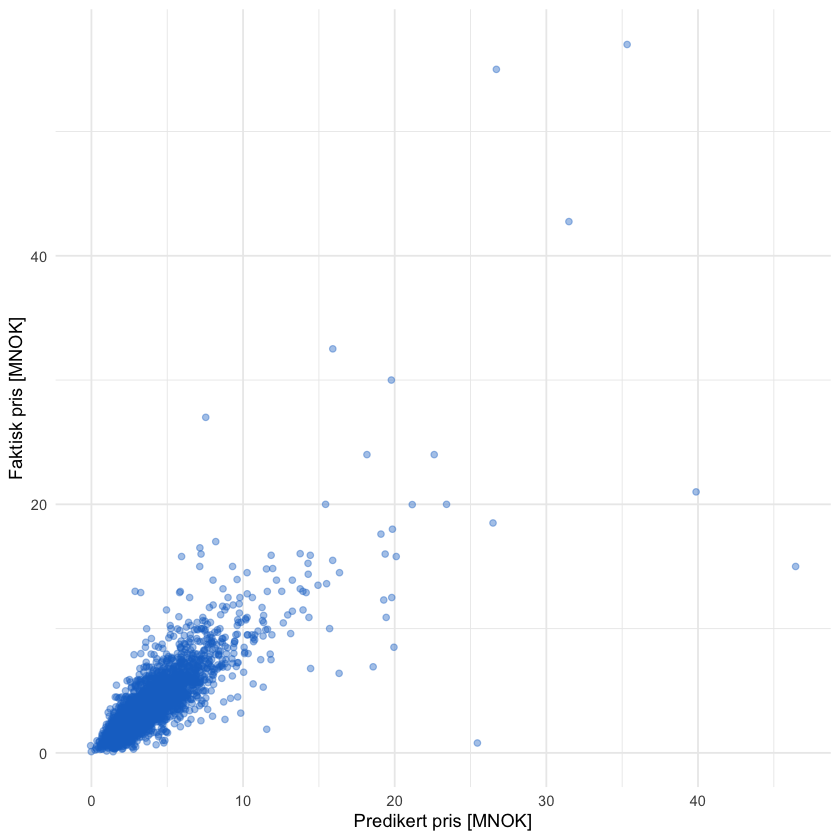

In [10]:
##################################### #
# Plot predictions ----
##################################### #
# Truth vs estimation
model_preds %>% 
  ggplot(aes(x = estimate/1000000, y = truth/1000000)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(x = "Predikert pris [MNOK]",
       y = "Faktisk pris [MNOK]") +
  theme_minimal()

Warning message:
“Removed 8 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


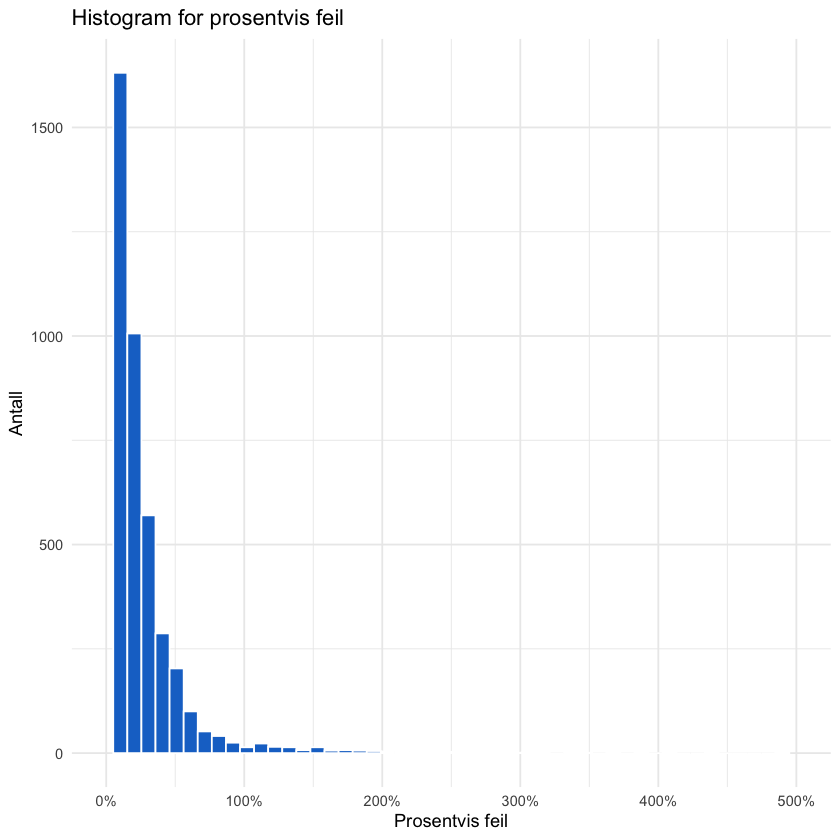

In [23]:
#Histogram of percentage error
model_preds %>%
  ggplot(aes(abs_dev_perc)) + 
  geom_histogram(fill = "dodgerblue3", color = "white", bins=50) +
  labs(title = "Histogram for prosentvis feil",
       x     = "Prosentvis feil",
       y     = "Antall") +
  scale_x_continuous(limits = c(0,5), labels = scales::percent) +
  theme_minimal()

Warning message:
“Removed 8 rows containing missing values (geom_point).”


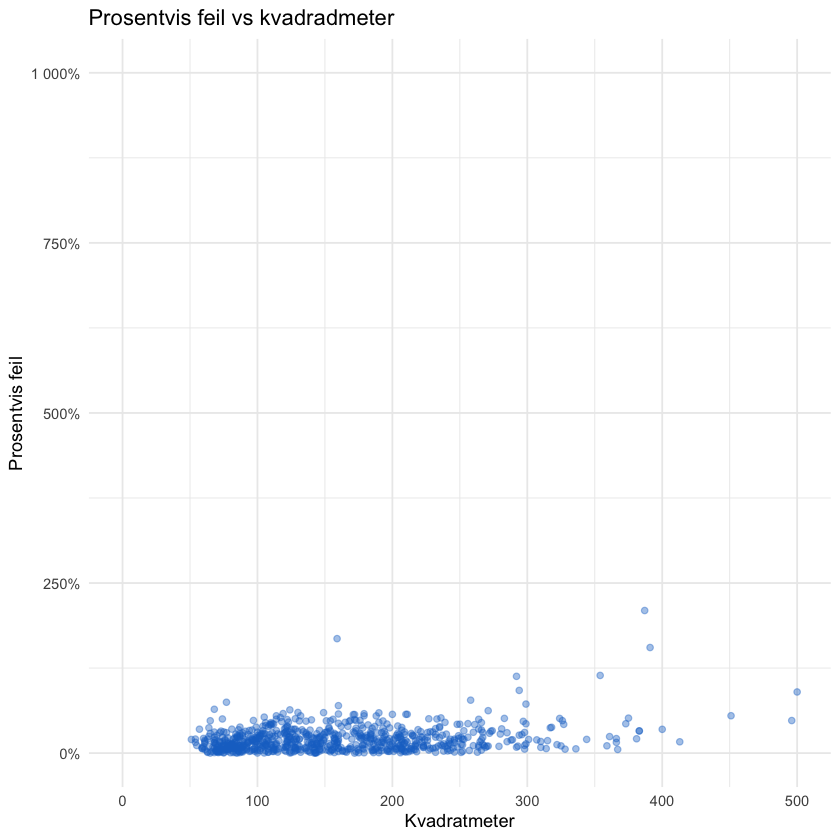

In [12]:
#Plot of abs_dev_perc by sqm (filter by total value > 5 million) 
model_preds %>%
  filter(truth > 5000000) %>%
  ggplot(aes(x = sqm, y = abs_dev_perc)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(title = "Prosentvis feil vs kvadradmeter",
       x     = "Kvadratmeter",
       y     = "Prosentvis feil") +
  scale_y_continuous(limits = c(0, 10), labels = scales::percent) +
  xlim(0, 500) +
  theme_minimal()

Warning message:
“Removed 2 rows containing missing values (geom_point).”


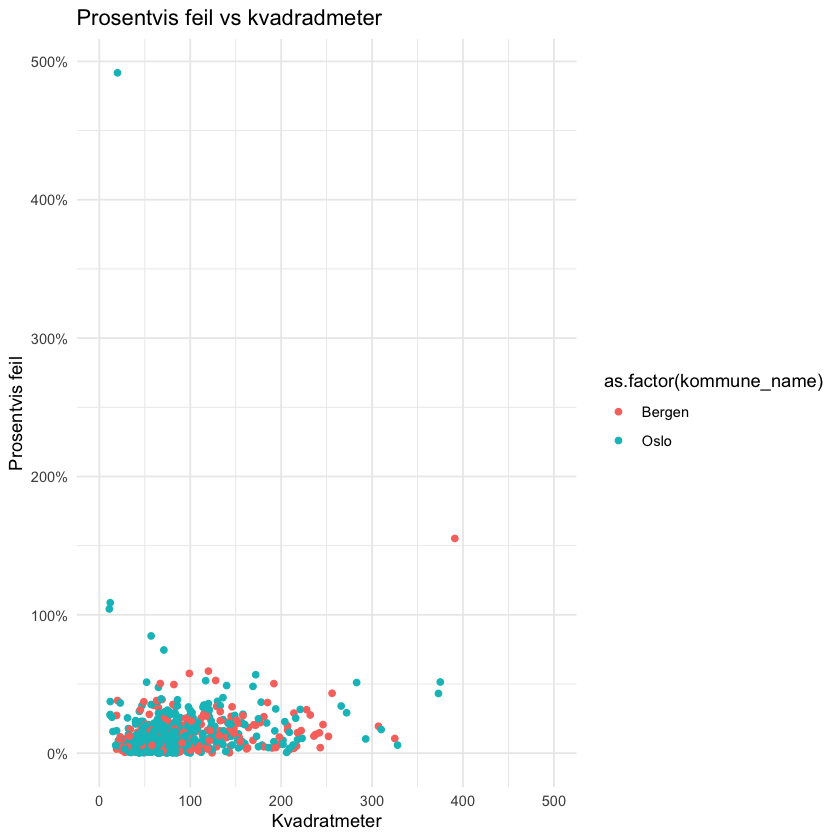

In [14]:
# Plot of abs_dev_perc by sqm (for Troms? and Bod?)
model_preds %>%
  filter(kommune_name == "Oslo" | kommune_name == "Bergen") %>%
  ggplot(aes(x = sqm, y = abs_dev_perc, color = as.factor(kommune_name))) +
  geom_point() +
  labs(title = "Prosentvis feil vs kvadradmeter",
       x     = "Kvadratmeter",
       y     = "Prosentvis feil") +
  scale_y_continuous(labels = scales::percent) + 
  xlim(0, 500) +
  theme_minimal() 

In [15]:
################### #
# Write prediction data to excel ----
################### #

write_xlsx(model_preds, "temp/predictions.xlsx")